learning rate is a step with which we change our parameters. if we decrease learning step, our parameters will change a little and very slow. if we increase learning rate than our parameters will change faster, but big learning rate is bad

we use regularization to avoid overfitting or underfitting of our model. if we increase regularization parameter too much we have a risk to underfit our data, if we decrease our regularization too much we have a risk to overfit data

error is how much our predictions differs from real rating. big error means that our model is very bad, little error means our model is good

In [9]:
lrs = [0.1, 0.001, 0.0001, 0.5, 0.05, 0.0005, 0.007, 0.002, 0.0003, 0.003]
regs = [0.1, 0.2, 0.3, 0.4, 0.02, 0.05, 0.07, 0.01, 0.06, 0.08]


In [2]:
import pandas as pd
from tqdm import tqdm
import numpy as np
train = pd.read_csv('ua.base', sep="\t", header=None)
train.columns = ['user_id', 'item_id', 'rating', 'timestamp']
train = train.drop(['timestamp'], axis=1)
train.user_id = train.user_id - 1
train.item_id = train.item_id - 1


test = pd.read_csv('ua.test', sep="\t", header=None)
test.columns = ['user_id', 'item_id', 'rating', 'timestamp']
test = test.drop(['timestamp'], axis=1)
test.user_id = test.user_id - 1
test.item_id = test.item_id - 1

In [3]:
rng = np.random.RandomState(42)
global_mean = train.rating.mean()
u_count = train.user_id.max() + 1
i_count = train.item_id.max() + 1
n_factors = 10
u_factors = rng.normal(0, 0.1, (u_count, n_factors))
i_factors = rng.normal(0, 0.1, (i_count, n_factors))
u_bias = np.zeros(shape=(u_count,))
i_bias = np.zeros(shape=(i_count,))
trainset = train.to_numpy()
testset = test.to_numpy()

In [4]:
def estimate(user_id, item_id):
    est = global_mean + u_bias[user_id] + i_bias[item_id]
    est += sum(u_factors[user_id] * i_factors[item_id])
    return est

def rmse(y_true, y_pred):
    return np.sqrt(((y_pred - y_true) **2).mean())

In [5]:
def predict(user_ids, item_ids):
    pred = []
    for u, i in zip(user_ids, item_ids):
        pred.append(estimate(u, i))
    return pred

In [6]:
params = []
for l in lr:
    for r in reg:
        params.append((l, r))

In [14]:
class SVDModel:
    def __init__(self, lr=0.1, reg=0.5, n_components=10, n_epochs=1, random_state=42):
        self.lr = lr
        self.reg = reg
        self.n_components = n_components
        self.n_epochs = n_epochs
        self.rng = np.random.RandomState(random_state)
        
        
    def fit(self, train):
        self.global_mean = train.rating.mean()
        self.u_count = train.user_id.max() + 1
        self.i_count = train.item_id.max() + 1
        self.u_factors = self.rng.normal(0, 0.1, (self.u_count, self.n_components))
        self.i_factors = self.rng.normal(0, 0.1, (self.i_count, self.n_components))
        self.u_bias = np.zeros(shape=(self.u_count,))
        self.i_bias = np.zeros(shape=(self.i_count,))
        self.trainset = train.to_numpy()
        
        for _ in tqdm(range(self.n_epochs)): 
            for u, i, r in self.trainset:
                pred = self.estimate(u, i)
                e = r - pred
                self.u_bias[u] = self.u_bias[u] + self.lr * (e - self.reg * self.u_bias[u])
                self.i_bias[i] = self.i_bias[i] + self.lr * (e - self.reg * self.i_bias[i])
                self.u_factors[u] = self.u_factors[u] + self.lr * (e * self.i_factors[i] - self.reg * self.u_factors[u])
                self.i_factors[i] = self.i_factors[i] + self.lr * (e * self.u_factors[u] - self.reg * self.i_factors[i])
        #return self.rmse(train['rating'], self.predict(train['user_id'], train['item_id']))
        
        
    def estimate(self, user_id, item_id):
        est = self.global_mean + self.u_bias[user_id] + self.i_bias[item_id]
        est += sum(self.u_factors[user_id] * self.i_factors[item_id])
        return est

    def predict(self, user_ids, item_ids):
        pred = []
        for u, i in zip(user_ids, item_ids):
            pred.append(self.estimate(u, i))
        return pred   
    
    def rmse(self, y_true, y_pred):
        return np.sqrt(((y_pred - y_true) **2).mean())

In [15]:
results = pd.DataFrame()
for lr in lrs:
    for reg in regs:
        m = SVDModel(lr=lr, reg=reg)
        m.fit(train)
        y_pred = m.predict(test.user_id, test.item_id)
        m.rmse(test.rating, y_pred)
        results = results.append(
        
        {
            'lr' : lr,
            'reg' : reg,
            'result' : m.rmse(test.rating, y_pred)
            
            
        }, ignore_index=True
        
        
        )
        print(lr, reg)

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

0.1 0.1


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

0.1 0.2


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

0.1 0.3


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

0.1 0.4


<ipython-input-14-50e9c804d3f1>:27: RuntimeWarning: overflow encountered in multiply
  self.i_factors[i] = self.i_factors[i] + self.lr * (e * self.u_factors[u] - self.reg * self.i_factors[i])
<ipython-input-14-50e9c804d3f1>:26: RuntimeWarning: overflow encountered in multiply
  self.u_factors[u] = self.u_factors[u] + self.lr * (e * self.i_factors[i] - self.reg * self.u_factors[u])
<ipython-input-14-50e9c804d3f1>:33: RuntimeWarning: invalid value encountered in double_scalars
  est += sum(self.u_factors[user_id] * self.i_factors[item_id])
<ipython-input-14-50e9c804d3f1>:33: RuntimeWarning: overflow encountered in multiply
  est += sum(self.u_factors[user_id] * self.i_factors[item_id])
<ipython-input-14-50e9c804d3f1>:26: RuntimeWarning: invalid value encountered in add
  self.u_factors[u] = self.u_factors[u] + self.lr * (e * self.i_factors[i] - self.reg * self.u_factors[u])
<ipython-input-14-50e9c804d3f1>:33: RuntimeWarning: overflow encountered in double_scalars
  est += sum(self.u_fact

0.1 0.02


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

0.1 0.05


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

0.1 0.07


<ipython-input-14-50e9c804d3f1>:27: RuntimeWarning: invalid value encountered in subtract
  self.i_factors[i] = self.i_factors[i] + self.lr * (e * self.u_factors[u] - self.reg * self.i_factors[i])
<ipython-input-14-50e9c804d3f1>:24: RuntimeWarning: invalid value encountered in double_scalars
  self.u_bias[u] = self.u_bias[u] + self.lr * (e - self.reg * self.u_bias[u])
<ipython-input-14-50e9c804d3f1>:25: RuntimeWarning: invalid value encountered in double_scalars
  self.i_bias[i] = self.i_bias[i] + self.lr * (e - self.reg * self.i_bias[i])
  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

0.1 0.01


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

0.1 0.06


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

0.1 0.08


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

0.001 0.1


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

0.001 0.2


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

0.001 0.3


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

0.001 0.4


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

0.001 0.02


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

0.001 0.05


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

0.001 0.07


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

0.001 0.01


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

0.001 0.06


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

0.001 0.08


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

0.0001 0.1


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

0.0001 0.2


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

0.0001 0.3


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

0.0001 0.4


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

0.0001 0.02


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

0.0001 0.05


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

0.0001 0.07


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

0.0001 0.01


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

0.0001 0.06


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

0.0001 0.08


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

0.5 0.1


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

0.5 0.2


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

0.5 0.3


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

0.5 0.4


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

0.5 0.02


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

0.5 0.05


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

0.5 0.07


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

0.5 0.01


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

0.5 0.06


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

0.5 0.08


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

0.05 0.1


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

0.05 0.2


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

0.05 0.3


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

0.05 0.4


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

0.05 0.02


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

0.05 0.05


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

0.05 0.07


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

0.05 0.01


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

0.05 0.06


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

0.05 0.08


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

0.0005 0.1


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

0.0005 0.2


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

0.0005 0.3


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

0.0005 0.4


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

0.0005 0.02


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

0.0005 0.05


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

0.0005 0.07


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

0.0005 0.01


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

0.0005 0.06


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

0.0005 0.08


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

0.007 0.1


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

0.007 0.2


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

0.007 0.3


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

0.007 0.4


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

0.007 0.02


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

0.007 0.05


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

0.007 0.07


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

0.007 0.01


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

0.007 0.06


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

0.007 0.08


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

0.002 0.1


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

0.002 0.2


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

0.002 0.3


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

0.002 0.4


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

0.002 0.02


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

0.002 0.05


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

0.002 0.07


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

0.002 0.01


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

0.002 0.06


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

0.002 0.08


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

0.0003 0.1


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

0.0003 0.2


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

0.0003 0.3


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

0.0003 0.4


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

0.0003 0.02


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

0.0003 0.05


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

0.0003 0.07


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

0.0003 0.01


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

0.0003 0.06


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

0.0003 0.08


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

0.003 0.1


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

0.003 0.2


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

0.003 0.3


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

0.003 0.4


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

0.003 0.02


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

0.003 0.05


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

0.003 0.07


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

0.003 0.01


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

0.003 0.06


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.91s/it]

0.003 0.08


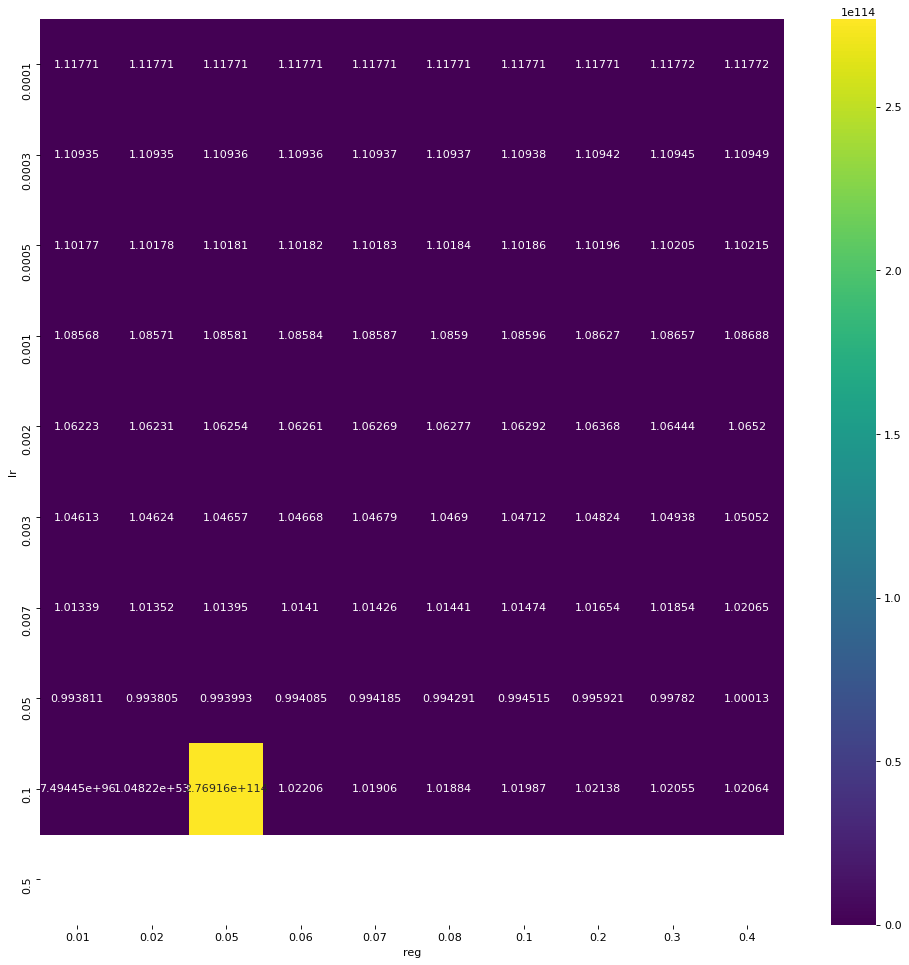

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(15, 15), dpi=80, facecolor='w', edgecolor='k')
to_show = results.pivot(index='lr', columns='reg', values='result')
sns.heatmap(to_show, annot=True, fmt="g", cmap='viridis')
plt.show()